## **Pratical Convolutional Networks in Pytorch - Image Classification**

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms as torchvision_transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data

C:\Users\eduar\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Specify the mean and standard deviation of all pixels in the MNIST dataset. They are precomputed
mean_gray=0.1307
stddev_gray=0.3081

#Transform the images to tensors
#Normalize a tensor image with mean and standard deviation. Given mean:(M1,...Mn) and std (S1,...,Sn)
#for n channels, this transform will normalize each channel of the input torch.Tensor 
#i.e input [channel]=(input[channel]-mean[channel])/std[channel]
# Transform the images to tensors and normalize
transform_pipeline = torchvision_transforms.Compose([
    torchvision_transforms.ToTensor(),
    torchvision_transforms.Normalize((mean_gray,), (stddev_gray,))
])

#Download the dataset:
train_dataset=datasets.MNIST(root='./data', train=True, transform=transform_pipeline, download=True)
test_dataset=datasets.MNIST(root='./data', train=False, transform=transform_pipeline, download=True)

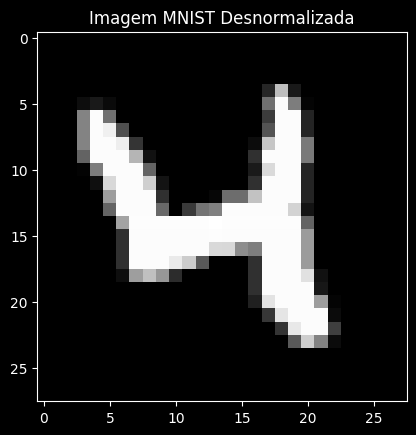

In [3]:
# Pegando uma imagem aleatória do dataset de treinamento
random_img_tensor = train_dataset[20][0]

# Desnormalizando a imagem
random_img = random_img_tensor.numpy() * stddev_gray + mean_gray

# Convertendo para imagem 2D
random_img = np.squeeze(random_img)  # Remover dimensões únicas

# Plotando a imagem
plt.imshow(random_img, cmap='gray')
plt.title("Imagem MNIST Desnormalizada")
plt.show()


In [4]:
print(train_dataset[20][1])

4


In [5]:
batch_size=100
train_loader=torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
len(train_loader)

600

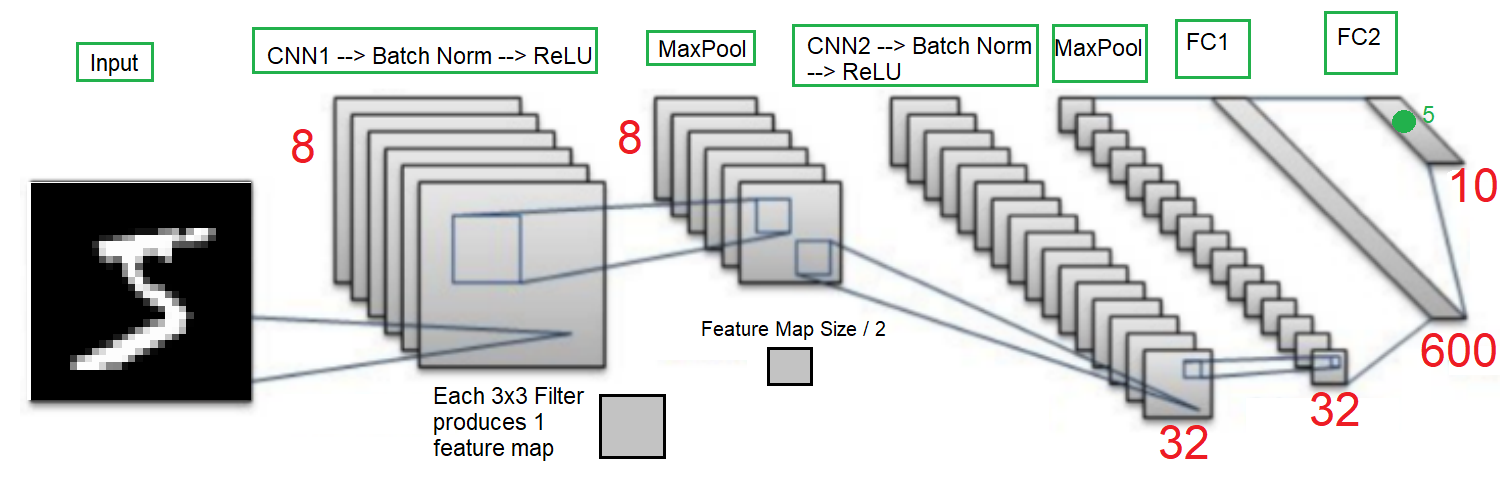

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        # Same padding --> input_size=output_size
        # Same padding = (filter_size-1)/2 -->(3-1)/2 = 1
        self.cnn1=nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
        # The ouput size of each of the 8 features maps:
        #[(input_size-filter_size + 2(padding))/stride + 1] = (28 - 3 + 2 )1 + 1 = 28
        self.batchnorm1=nn.BatchNorm2d(8)
        self.relu=nn.ReLU()
        self.maxpool=nn.MaxPool2d(kernel_size=2)
        #The output size = 28/2  = 14
        #Same padding = (filter_size-1)/2 -->(5-1)/2 = 2
        self.cnn2=nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride=1, padding=2)
        # Output Size of each of the 32 features maps [(14 - 5 + 2(2)/1 + 1)] = 14
        self.batchnorm2=nn.BatchNorm2d(32)
        # Flatten the 32 features maps: 7*7*32=1568
        self.fc1=nn.Linear(1568,600)
        self.dropout=nn.Dropout(p=0.5)
        self.fc2=nn.Linear(600,10)


    def forward(self, x):
        out=self.cnn1(x)
        out=self.batchnorm1(out)
        out=self.relu(out)
        out=self.maxpool(out)
        out=self.cnn2(out)
        out=self.batchnorm2(out)
        out=self.relu(out)
        out=self.maxpool(out)    
        # Flatten the 32 features maps from to Max Pool to feed it to the FC1 (100, 1568)
        out=out.view(-1,1568)
        #Then we forward through our fully connected layer
        out=self.fc1(out)
        out=self.relu(out)
        out=self.dropout(out)
        out=self.fc2(out)
        return out 

In [8]:
model=CNN()
CUDA=torch.cuda.is_available()
if CUDA:
    model=model.cuda()

loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.01)    

In [9]:
# Understand what's happening

iteration=0
correct=0

for i, (inputs,labels) in enumerate(train_loader):
    if CUDA:
        inputs=inputs.cuda()
        labels=labels.cuda()

    print('For one iteration, this is what happens: ')
    # Each tensor propogated through the network should be 4D (batch_size, channels, rows, columns )
    print('Input Shape:', inputs.shape)
    print('Labels Shape:', labels.shape)
    output=model(inputs)
    print('Outputs Shape', output.shape)
    _,predicted=torch.max(output,1)
    print('Predicted Shape:', predicted.shape)
    print('Predicted Tensor:')
    print(predicted)
    correct+=(predicted==labels).sum()
    break


For one iteration, this is what happens: 
Input Shape: torch.Size([100, 1, 28, 28])
Labels Shape: torch.Size([100])
Outputs Shape torch.Size([100, 10])
Predicted Shape: torch.Size([100])
Predicted Tensor:
tensor([3, 3, 3, 6, 7, 6, 3, 3, 6, 6, 3, 8, 9, 9, 2, 9, 2, 2, 8, 6, 1, 9, 9, 9,
        7, 6, 9, 1, 6, 2, 2, 7, 9, 4, 2, 3, 9, 2, 2, 7, 9, 9, 2, 6, 8, 9, 2, 9,
        2, 2, 9, 9, 9, 2, 6, 9, 9, 3, 2, 9, 9, 9, 9, 2, 2, 9, 9, 6, 2, 9, 9, 9,
        7, 7, 9, 2, 9, 2, 3, 6, 6, 2, 2, 3, 9, 9, 2, 9, 2, 3, 9, 2, 6, 6, 9, 7,
        5, 8, 9, 2])


In [10]:
# Training the CNN
num_epochs = 10
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

for epoch in range(num_epochs):
    correct = 0
    iterations = 0
    iter_loss = 0.0

    model.train()

    for i, (inputs, labels) in enumerate(train_loader):

        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()

        # Forward propagation:
        outputs = model(inputs)

        # Calculate the loss:
        loss = loss_fn(outputs, labels)
        iter_loss += loss.item()

        optimizer.zero_grad()  # w <-- w - lr*gradient

        # Backpropagation:
        loss.backward()
        optimizer.step()  # Update the weights 

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        iterations += 1  # Fixed the typo here

    train_loss.append(iter_loss / iterations)
    train_accuracy.append((100 * correct / len(train_dataset)))

    # Testing Phase:
    test_loss_epoch = 0.0
    correct = 0
    iterations = 0

    model.eval()

    for i, (inputs, labels) in enumerate(test_loader):

        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs = model(inputs)  # Forward
        loss = loss_fn(outputs, labels)
        test_loss_epoch += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        iterations += 1

    test_loss.append(test_loss_epoch / iterations)
    test_accuracy.append((100 * correct) / len(test_dataset))

    print("Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Test Loss: {:.3f}, Test Accuracy: {:.3f}".format(
        epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], test_loss[-1], test_accuracy[-1]))

Epoch 1/10, Training Loss: 0.971, Training Accuracy: 68.280, Test Loss: 0.120, Test Accuracy: 96.570
Epoch 2/10, Training Loss: 0.243, Training Accuracy: 92.137, Test Loss: 0.083, Test Accuracy: 97.640
Epoch 3/10, Training Loss: 0.126, Training Accuracy: 96.292, Test Loss: 0.053, Test Accuracy: 98.300
Epoch 4/10, Training Loss: 0.100, Training Accuracy: 97.233, Test Loss: 0.054, Test Accuracy: 98.440
Epoch 5/10, Training Loss: 0.084, Training Accuracy: 97.572, Test Loss: 0.047, Test Accuracy: 98.740
Epoch 6/10, Training Loss: 0.073, Training Accuracy: 97.877, Test Loss: 0.049, Test Accuracy: 98.670
Epoch 7/10, Training Loss: 0.072, Training Accuracy: 97.993, Test Loss: 0.042, Test Accuracy: 98.740
Epoch 8/10, Training Loss: 0.062, Training Accuracy: 98.188, Test Loss: 0.035, Test Accuracy: 98.890
Epoch 9/10, Training Loss: 0.063, Training Accuracy: 98.260, Test Loss: 0.048, Test Accuracy: 98.830
Epoch 10/10, Training Loss: 0.060, Training Accuracy: 98.313, Test Loss: 0.041, Test Accura

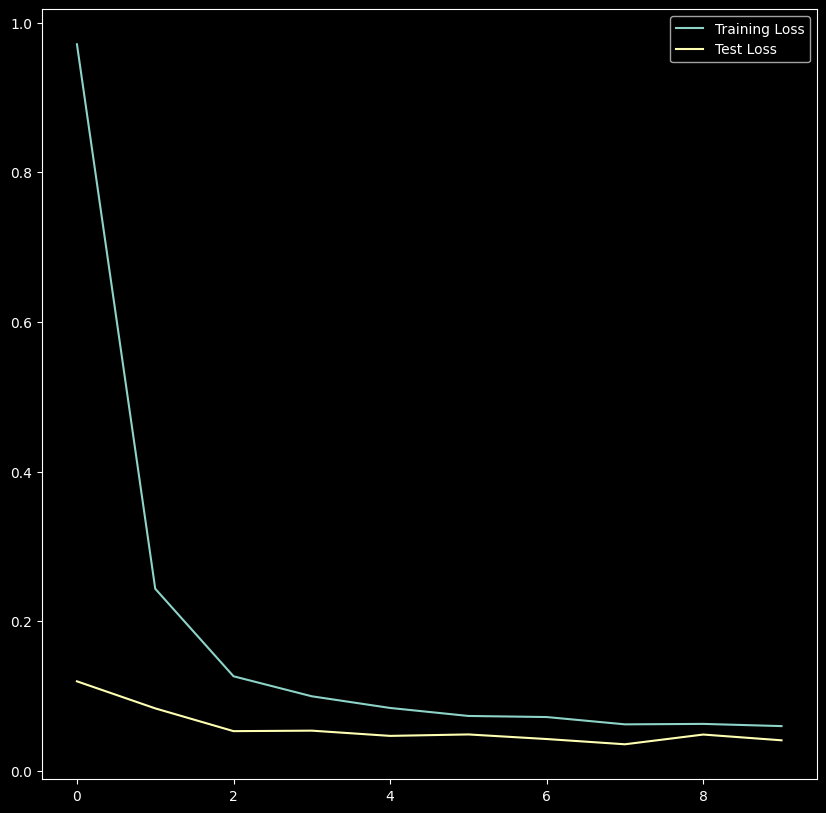

In [11]:
# Plotting the loss:
f=plt.figure(figsize=(10,10))
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Test Loss')
plt.legend()
plt.show()

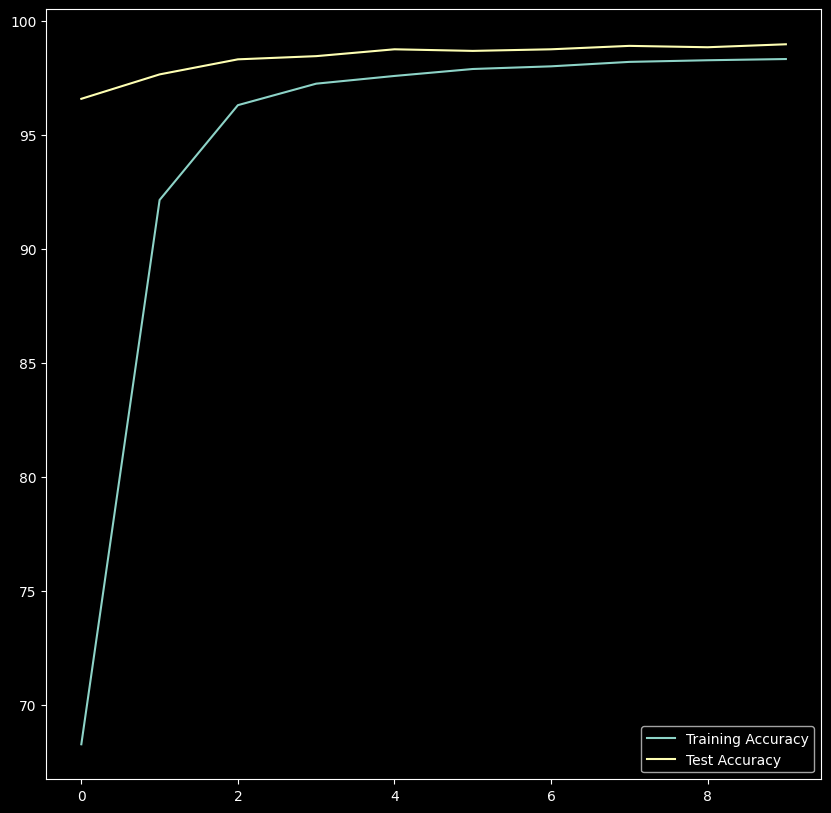

In [12]:
# Plotting the accuracy:
f=plt.figure(figsize=(10,10))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.legend()
plt.show()

In [15]:
img=test_dataset[20][0].resize_((1,1,28,28))
label=test_dataset[20][1]

model.eval()

if CUDA:
    model = model.cuda()
    img = img.cuda()

outputs = model(img)
_,predicted = torch.max(outputs,1)
print("Prediction is: {}".format(predicted.item()))
print("Actual is: {}".format(label))

Prediction is: 4
Actual is: 9


Prediction is: 5
Actual is: 3


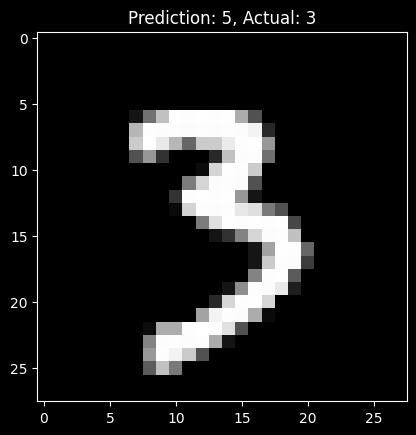

In [14]:
model = CNN()
model.eval()

# Use CUDA if available
CUDA = torch.cuda.is_available()
if CUDA:
    model = model.cuda()

# Carregar a imagem e seu rótulo do dataset de teste
img, label = test_dataset[30]
img = img.unsqueeze(0)  # Adicionar dimensão de batch

if CUDA:
    img = img.cuda()

# Realizar a predição
outputs = model(img)
_, predicted = torch.max(outputs, 1)
print("Prediction is: {}".format(predicted.item()))
print("Actual is: {}".format(label))

# Desnormalizar a imagem para visualização
img = img.cpu().squeeze().numpy() * stddev_gray + mean_gray

# Visualizar a imagem com a predição
plt.imshow(img, cmap='gray')
plt.title(f"Prediction: {predicted.item()}, Actual: {label}")
plt.show()